<a href="https://colab.research.google.com/github/Donfac/data-analysis-project/blob/main/complaint_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analyser automatiquement les plaintes des citoyens afin d’extraire les informations importantes, en particulier les thèmes les plus fréquents, pour aider les décideurs à mieux comprendre les problèmes majeurs rencontrés par la population et ainsi orienter les actions ou solutions à mettre en place.

I - IMPORT

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Datas/311_Service_Requests_from_2010_to_Present.csv")

/tmp/ipython-input-3941156233.py:2: DtypeWarning: Columns (48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/Datas/311_Service_Requests_from_2010_to_Present.csv")


In [ ]:
df.head(4)

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,32310363,12/31/2015 11:59:45 PM,01/01/2016 12:55:15 AM,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,10034.0,71 VERMILYEA AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.865682,-73.923501,"(40.86568153633767, -73.92350095571744)"
1,32309934,12/31/2015 11:59:44 PM,01/01/2016 01:26:57 AM,NYPD,New York City Police Department,Blocked Driveway,No Access,Street/Sidewalk,11105.0,27-07 23 AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.775945,-73.915094,"(40.775945312321085, -73.91509393898605)"
2,32309159,12/31/2015 11:59:29 PM,01/01/2016 04:51:03 AM,NYPD,New York City Police Department,Blocked Driveway,No Access,Street/Sidewalk,10458.0,2897 VALENTINE AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.870325,-73.888525,"(40.870324522111424, -73.88852464418646)"
3,32305098,12/31/2015 11:57:46 PM,01/01/2016 07:43:13 AM,NYPD,New York City Police Department,Illegal Parking,Commercial Overnight Parking,Street/Sidewalk,10461.0,2940 BAISLEY AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.835994,-73.828379,"(40.83599404683083, -73.82837939584206)"


In [ ]:
df['Resolution Description'].iloc[1]

'The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.'

In [ ]:
df.shape

(364558, 53)

In [ ]:
pip install nltk

In [ ]:
#importation des bibliotheques
import nltk
import spacy
from nltk.corpus import stopwords

In [ ]:
# Télécharger les stopwords et le modèle spaCy
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Supprimer les lignes vides ou NaN
df = df.dropna(subset=['Resolution Description'])

II - CLEANING

In [ ]:
import re

In [ ]:
# Nettoyage et lemmatisation
def preprocess_text(text):
    # Mise en minuscule
    text = text.lower()
    # Suppression des caractères spéciaux, chiffres, ponctuations
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenisation et lemmatisation
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and token.is_alpha]
    return " ".join(tokens)

In [ ]:
# Appliquer le nettoyage à la colonne
df['cleaned_text'] = df['Resolution Description'].apply(preprocess_text)

In [ ]:
# Aperçu
df[['Resolution Description', 'cleaned_text']].head()

,Resolution Description,cleaned_text
0,The Police Department responded and upon arriv...,police department respond upon arrival respons...
1,The Police Department responded to the complai...,police department respond complaint informatio...
2,The Police Department responded and upon arriv...,police department respond upon arrival respons...
3,The Police Department responded to the complai...,police department respond complaint take actio...
4,The Police Department responded and upon arriv...,police department respond upon arrival respons...


III- VECTORISATION

In [ ]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Limiter à 5000 mots max pour éviter de saturer la mémoire
max_features = 5000

# 1. CountVectorizer
count_vectorizer = CountVectorizer(max_features=max_features)
X_count = count_vectorizer.fit_transform(df['cleaned_text'])

print("CountVectorizer shape:", X_count.shape)

CountVectorizer shape: (364558, 100)


In [ ]:
# 2. TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])

print("TF-IDF shape:", X_tfidf.shape)

TF-IDF shape: (364558, 100)


IV - Extraction des sujets dominants

1 - modélisation LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

# Appliquer LDA sur la matrice CountVectorizer
n_topics = 10  # Tu peux changer ce nombre pour extraire plus de sujets
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_model.fit(X_count)

# Afficher les 10 mots les plus représentatifs de chaque sujet
words = count_vectorizer.get_feature_names_out()

for i, topic in enumerate(lda_model.components_):
    print(f"\n Sujet {i+1}:")
    top_words = topic.argsort()[-10:][::-1]  # 10 mots les plus fréquents
    print(" ".join([words[j] for j in top_words]))


 Sujet 1:
contact request information service please new provide time nycgov insufficient

 Sujet 2:
department police complaint jurisdiction fall respond prepare report condition information

 Sujet 3:
police determine complaint department respond necessary action longterm conclusion park

 Sujet 4:
appropriate day receive submit comment agency city call unit follow

 Sujet 5:
respond complaint department police available observe evidence violation time information

 Sujet 6:
police department condition respond arrival go responsible upon vehicle tow

 Sujet 7:
york forward additional number note reference future response nonemergency hour

 Sujet 8:
department police complaint information review provide additional gain unable entry

 Sujet 9:
police department complaint response issue summon arrest make may new

 Sujet 10:
respond take fix condition action complaint department police prepare report


Les themes principaux : plaintes liées à la police, délais de réponse, conditions, véhicules/remorquages, convocations et arrestations.

Interpretation  : les grandes thématiques récurrentes dans les plaintes sont liées à l’intervention de la police, le suivi des plaintes, les véhicules/remorquages, les délais de réponse et les convocations

2 - kmeans pour regrouper les textes similaires

In [ ]:
from sklearn.cluster import KMeans

# Appliquer KMeans sur les vecteurs TF-IDF
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_tfidf)

# Ajouter les clusters dans le DataFrame
df['kmeans_cluster'] = kmeans.labels_

# Afficher un échantillon
df[['Resolution Description', 'cleaned_text', 'kmeans_cluster']].sample(5)


,Resolution Description,cleaned_text,kmeans_cluster
311318,The Police Department responded and upon arriv...,police department respond upon arrival respons...,1
51687,The Police Department issued a summons in resp...,police department issue summon response complaint,3
117752,The Police Department responded and upon arriv...,police department respond upon arrival respons...,1
95052,The Police Department responded to the complai...,police department respond complaint take actio...,2
170789,The Police Department responded to the complai...,police department respond complaint determine ...,4


lire quelques exemples de clusters

In [ ]:
# Pour afficher les colonnes entières (pas de coupure de texte)
pd.set_option("display.max_colwidth", None)

for i in range(n_clusters):
    print(f"\nCluster {i}")
    print(
        df[df['kmeans_cluster'] == i]['Resolution Description']
        .sample(3, random_state=1)
        .to_string(index=False)
    )


Cluster 0
The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.
                                               The Police Department reviewed your complaint and provided additional information below.
The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.

Cluster 1
The Police Department responded and upon arrival those responsible for the condition were gone.
The Police Department responded and upon arrival those responsible for the condition were gone.
The Police Department responded and upon arrival those responsible for the condition were gone.

Cluster 2
The Police Department responded to the complaint and took action to fix the condition.
The Police Department responded to the complaint and took action to fix the condition.
The Police Department responded to the complaint and took action to fix the condition.

Cluster 3

In [ ]:
for i in range(n_clusters):
    print(f"\n Cluster {i}")
    print(df[df['kmeans_cluster'] == i]['Resolution Description'].sample(3, random_state=1).to_string(index=False))



 Cluster 0
The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.
                                               The Police Department reviewed your complaint and provided additional information below.
The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.

 Cluster 1
The Police Department responded and upon arrival those responsible for the condition were gone.
The Police Department responded and upon arrival those responsible for the condition were gone.
The Police Department responded and upon arrival those responsible for the condition were gone.

 Cluster 2
The Police Department responded to the complaint and took action to fix the condition.
The Police Department responded to the complaint and took action to fix the condition.
The Police Department responded to the complaint and took action to fix the condition.

 Clust

Interpretation : Les plaintes sont regroupées selon le type de réponse : simple accusé de réception, intervention, convocation, arrestation.

Conclusion : Les plaintes citoyennes révèlent principalement des problèmes avec la police, surtout liés au suivi, aux délais et aux actions entreprises. On distingue plusieurs catégories de réponses (simple réponse, intervention, convocation, arrestation). Ces résultats permettent d’orienter les décisions vers l’amélioration du traitement et du suivi des plaintes.

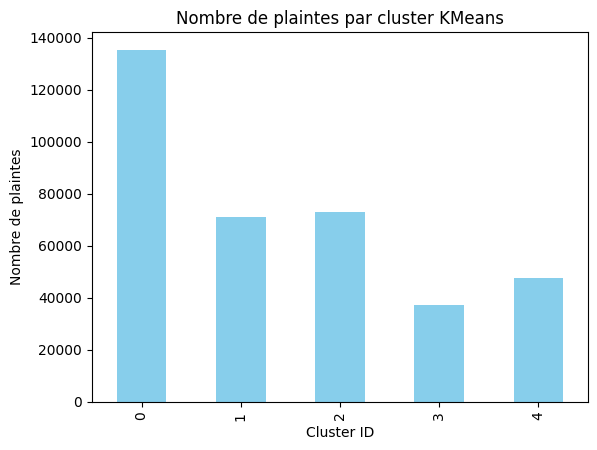

In [ ]:
import matplotlib.pyplot as plt

df['kmeans_cluster'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Nombre de plaintes par cluster KMeans")
plt.xlabel("Cluster ID")
plt.ylabel("Nombre de plaintes")
plt.show()

/tmp/ipython-input-3836233801.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Created Date'] = pd.to_datetime(df['Created Date'])


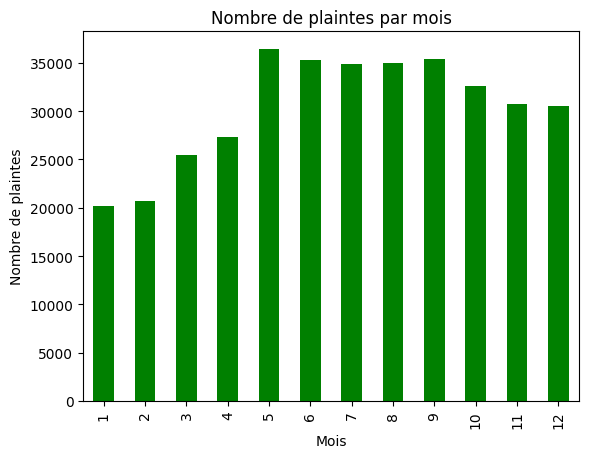

In [ ]:
df['Created Date'] = pd.to_datetime(df['Created Date'])
df['Month'] = df['Created Date'].dt.month

df['Month'].value_counts().sort_index().plot(kind='bar', color='green')
plt.title("Nombre de plaintes par mois")
plt.xlabel("Mois")
plt.ylabel("Nombre de plaintes")
plt.show()